In [20]:
import sys
import time
import tracemalloc
import matplotlib.pyplot as plt
import string
import random
from collections import deque 
from typing import List, Dict, Tuple, Optional, Any 

sys.setrecursionlimit(10**6) # moze wystarczy :)

### Algorytmy

Impelmentacje oparte o algorytmy z poprzednich laboratoriów( lekko zmienione w celach analizy danych)

In [21]:
def naive_pattern_match_modified(text: str, pattern: str) -> tuple[list[int], int]:
    comparisons = 0
    if not pattern or not text or len(pattern) > len(text):
        return [], comparisons
    
    n_text = len(text)
    m_pattern = len(pattern)
    positions = []
    
    for i in range(n_text - m_pattern + 1):
        match = True
        for j in range(m_pattern):
            comparisons += 1 
            if text[i + j] != pattern[j]:
                match = False
                break
        if match:
            positions.append(i)
            
    return positions, comparisons

In [22]:
def compute_lps_array_modified(pattern: str) -> tuple[list[int], int]:
    n = len(pattern)
    lps = [0] * n  
    comparisons_lps = 0
    length = 0 
    i = 1
    while i < n:
        comparisons_lps += 1 
        if pattern[i] == pattern[length]:
            length += 1
            lps[i] = length
            i += 1
        else:
            if length != 0:
                length = lps[length - 1]
            else:
                lps[i] = 0
                i += 1
    return lps, comparisons_lps

In [2]:
def compute_lps_array(pattern: str) -> list[int]:
    n = len(pattern)
    lps = [0] * n  

    length = 0 # naj pref
    i = 1
    
    while i < n:
        if pattern[i] == pattern[length]:
            length += 1
            lps[i] = length
            i += 1
        else:
            # jesli nie machuja
            if length != 0: length = lps[length - 1]
            else: # jesli nie ma gdzie wrocic
                lps[i] = 0
                i += 1
    return lps

def kmp_pattern_match(text: str, pattern: str) -> list[int]:
    if not pattern or not text: return []

    lps = compute_lps_array(pattern)
    
    n = len(text)
    m = len(pattern)
    i = 0  # text
    j = 0  # pattern
    positions = [] # miejsca matchów
    
    while i < n:
        if text[i] == pattern[j]:
            i += 1
            j += 1
        
        if j == m: # caly pattern sie pokrywa
            positions.append(i - j) 
            j = lps[j - 1]  # wracamy lps tablem
        
        elif i < n and text[i] != pattern[j]:
            if j != 0:
                j = lps[j - 1]  # wracamy lps tablem
            else:
                i += 1
    
    return positions

In [3]:
def compute_bad_character_table(pattern: str) -> dict:
    if not pattern: return {}
    d = {}
    n = len(pattern)
    for i in range(n-1,-1,-1):
        if pattern[i] not in d: d[pattern[i]] = i
    return d

def compute_good_suffix_table(pattern: str) -> list[int]:
    if not pattern: return []
    n = len(pattern)
    shift = [1] * (n + 1)

    if all(c == pattern[0] for c in pattern):
        for i in range(1, n + 1):
            if i == 1: shift[i-1] = 1
            else: shift[i-1] = i - 1
        shift[n] = n 
        
    return shift

def boyer_moore_pattern_match(text: str, pattern: str) -> list[int]:
    if not pattern or not text: return []

    bad_char = compute_bad_character_table(pattern)
    good_suffix = compute_good_suffix_table(pattern)
    
    m = len(pattern)
    n = len(text)
    positions = []
 
    i = 0
    while i <= n - m:
        j = m - 1
        while j >= 0 and pattern[j] == text[i + j]: j -= 1
        if j < 0:
            positions.append(i)
            i += 1
        else:
            i += max(1, j - bad_char.get(text[i + j], -1))
    
    return positions

In [4]:
def naive_pattern_match(text: str, pattern: str) -> list[int]:
    return [] if len(text) < len(pattern) or not pattern else [start for start in range(len(text)-len(pattern)+1) if text[start:start+len(pattern)] == pattern ]

In [5]:
def rabin_karp_pattern_match(text: str, pattern: str, prime: int = 101) -> list[int]:
    
    if not pattern or not text or len(pattern) > len(text):return []
   
    m = len(pattern)
    n = len(text)
    matches = []

    h = 1 # hash dla sliding window
    for _ in range(m - 1):
        h = (h * 100) % prime
   
    p_hash = 0  # pattern
    t_hash = 0  # obecne okno textu
    
    for i in range(m):
        p_hash = (100 * p_hash + ord(pattern[i])) % prime
        t_hash = (100 * t_hash + ord(text[i])) % prime

    for i in range(n - m + 1): # m dlugosciowe odcinki
        if p_hash == t_hash:
            match = True
            for j in range(m):
                if text[i + j] != pattern[j]:
                    match = False
                    break
            if match: matches.append(i)
    
        if i < n - m:
            t_hash = (100 * (t_hash - ord(text[i]) * h) + ord(text[i + m])) % prime # rehaszujemy suuwamy i dodajemy
    
    return matches

In [8]:
class AhoCorasickNode:
    def __init__(self):
        self.transitions: Dict[str, 'AhoCorasickNode'] = {} # przejscie
        
        self.failure_link: Optional['AhoCorasickNode'] = None # inny wezle w przypadku braku dopasowanai
        
        self.output: List[str] = [] # konczace sie na tym wezle


class AhoCorasick:
    def __init__(self, patterns: List[str]):

        self.patterns = [p for p in patterns if p] # usuwanie pustych
        self.root = AhoCorasickNode()
        
        # budwoanie struktry
        self._build_trie()
        self._build_failure_links()

    def _build_trie(self):
        for pattern in self.patterns: # kadzy wzorzec do drzewa
            current_node = self.root

            for char in pattern: # kazdy znak do drzewa
                if char not in current_node.transitions: current_node.transitions[char] = AhoCorasickNode()
                current_node = current_node.transitions[char]
            # dodajemy wzorzec do listy wyjsc dla ostatniego wezla
            current_node.output.append(pattern)

    def _build_failure_links(self):
        queue = deque() # kolejka do bfsa
        
        # lacze awaryjne dla wezlow
        for char, node in self.root.transitions.items():
            node.failure_link = self.root
            queue.append(node)
        
        # BFS
        while queue:
            current_node = queue.popleft()
            
            # dla przejść
            for char, child_node in current_node.transitions.items():
                queue.append(child_node)
                
                # lacze awaryjne dla dziecka
                failure_node = current_node.failure_link
                
                # szukamy wezla pod lacze awaryjne
                while failure_node is not self.root and char not in failure_node.transitions: failure_node = failure_node.failure_link
                # jesli przejscie dla znaku istnieje, ustawiamy lacze, jesli nie wskazujemy korzen
                if char in failure_node.transitions:
                    child_node.failure_link = failure_node.transitions[char]
                else:
                    child_node.failure_link = self.root
                
                # wyjscie przez lacze awaryjne
                child_node.output += child_node.failure_link.output

    def search(self, text: str) -> List[Tuple[int, str]]:
        """
        Searches for all occurrences of patterns in the given text.

        Returns:
            List of tuples (start_index, pattern).
        """
        results = []
        if not self.patterns: return results
        
        current_node = self.root
        
        for i, char in enumerate(text):
            # znajdzie przejscie
            while current_node is not self.root and char not in current_node.transitions: current_node = current_node.failure_link
            
            # jesli jest, przejdz do wezla
            if char in current_node.transitions:
                current_node = current_node.transitions[char]
                
                # czy w tym wezle koczy sie wzorzec
                for pattern in current_node.output:
                    # znadjuejmy pozycje poczatkowa
                    start_index = i - len(pattern) + 1
                    results.append((start_index, pattern))
        
        return results

In [9]:
def benchmark_algorithm(algorithm_fn, text, pattern, is_multiple=False) -> Dict[str, float]:
    tracemalloc.start()
    start_time = time.time()

    # Wykonaj dopasowanie
    matches = algorithm_fn(text, pattern) if not is_multiple else algorithm_fn(text, pattern, is_multiple)

    end_time = time.time()
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    return {
        "matches": matches,
        "time_ms": (end_time - start_time) * 1000,
        "memory_kb": peak / 1024
    }


In [11]:
def build_suffix_array(text: str):
    return sorted(range(len(text)), key=lambda i: text[i:])

def suffix_array_match(text: str, pattern: str) -> List[int]:
    if not pattern:
        return []
    
    suffixes = sorted((text[i:], i) for i in range(len(text)))
    left, right = 0, len(suffixes)
    result = []
    while left < right:
        mid = (left + right) // 2
        if suffixes[mid][0].startswith(pattern):
            right = mid
        elif suffixes[mid][0] < pattern:
            left = mid + 1
        else:
            right = mid
    start = left

    while start < len(suffixes) and suffixes[start][0].startswith(pattern):
        result.append(suffixes[start][1])
        start += 1

    return sorted(result)


In [12]:
class Node:
    def __init__(self):
        self.children = {}
        self.suffix_link = None
        self.start = -1
        self.end = -1
        self.id = -1
        self.suffix_start = -1

class SuffixTree:
    def __init__(self, text: str):
        self.text = text + "$"
        self.n = len(self.text)
        self.root = Node()
        self.root.suffix_link = self.root
        self.active_node = self.root
        self.active_edge = 0
        self.active_length = 0
        self.remainder = 0
        self.global_end = -1
        self.node_count = 0
        self.build_tree()

    def get_edge_length(self, node):
        if node.end == -1:
            return self.global_end - node.start + 1
        else:
            return node.end - node.start + 1

    def walk_down(self, node):
        edge_length = self.get_edge_length(node)
        if self.active_length >= edge_length:
            self.active_edge += edge_length
            self.active_length -= edge_length
            self.active_node = node
            return True
        return False

    def new_node(self, start, end=None):
        """
        Tworzy nowy węzeł z podanymi parametrami.
        """
        node = Node()
        node.start = start
        if end is None:
            node.end = -1  # globalny koniec dla liści
        else:
            node.end = end
        node.id = self.node_count
        self.node_count += 1
        return node

    def build_tree(self):
        """
        Buduje drzewo sufiksów używając algorytmu Ukkonena.
        """
        for i in range(self.n):
            # Rozszerzamy globalny koniec (optymalizacja wskaźnika końcowego)
            self.global_end = i
            self.remainder += 1
            
            last_new_node = None
            
            while self.remainder > 0:
                if self.active_length == 0:
                    self.active_edge = i
                
                # Sprawdzamy czy istnieje krawędź z active_node zaczynająca się od active_edge
                if self.text[self.active_edge] not in self.active_node.children:
                    # Nie ma takiej krawędzi - tworzymy nowy liść
                    leaf = self.new_node(i)
                    leaf.suffix_start = i - self.remainder + 1  # pozycja początku sufiksu
                    self.active_node.children[self.text[self.active_edge]] = leaf
                    
                    # Implementacja reguły 3 (łącza sufiksowe)
                    if last_new_node is not None:
                        last_new_node.suffix_link = self.active_node
                        last_new_node = None
                else:
                    # Krawędź istnieje
                    next_node = self.active_node.children[self.text[self.active_edge]]
                    
                    # Technika skip/count
                    if self.walk_down(next_node):
                        continue
                    
                    # Sprawdzamy czy możemy kontynuować po istniejącej krawędzi
                    if self.text[next_node.start + self.active_length] == self.text[i]:
                        # Reguła 3: kończymy fazę jeśli możemy kontynuować
                        if last_new_node is not None and self.active_node != self.root:
                            last_new_node.suffix_link = self.active_node
                            last_new_node = None
                        
                        self.active_length += 1
                        break
                    
                    # Musimy rozdzielić krawędź
                    split_end = next_node.start + self.active_length - 1
                    split_node = self.new_node(next_node.start, split_end)
                    self.active_node.children[self.text[self.active_edge]] = split_node
                    
                    # Tworzymy nowy liść
                    leaf = self.new_node(i)
                    leaf.suffix_start = i - self.remainder + 1
                    split_node.children[self.text[i]] = leaf
                    next_node.start += self.active_length
                    split_node.children[self.text[next_node.start]] = next_node
                    
                    # Implementacja reguły 3
                    if last_new_node is not None:
                        last_new_node.suffix_link = split_node
                    
                    last_new_node = split_node
                
                self.remainder -= 1
                
                if self.active_node == self.root and self.active_length > 0:
                    self.active_length -= 1
                    self.active_edge = i - self.remainder + 1
                elif self.active_node != self.root:
                    # Sprawdzamy czy suffix_link istnieje, jeśli nie - idziemy do root
                    if self.active_node.suffix_link is not None:
                        self.active_node = self.active_node.suffix_link
                    else:
                        self.active_node = self.root

    def find_pattern(self, pattern: str) -> list[int]:
        if not pattern:
            return []
        
        current_node = self.root
        pattern_pos = 0
        pattern_len = len(pattern)
        
        while pattern_pos < pattern_len:
            char = pattern[pattern_pos]
            if char not in current_node.children:
                return []
            
            next_node = current_node.children[char]
            edge_len = self.get_edge_length(next_node)
            compare_len = min(edge_len, pattern_len - pattern_pos)
            
            edge_text = self.text[next_node.start:next_node.start + compare_len]
            pattern_part = pattern[pattern_pos:pattern_pos + compare_len]
            
            if edge_text != pattern_part:
                return []
            
            pattern_pos += compare_len
            current_node = next_node
        
        positions = []
        self._collect_leaves(current_node, positions)
        return sorted(list(set(positions)))

    def _collect_leaves(self, node, positions):
        """
        Rekurencyjnie zbiera wszystkie liście z poddrzewa.
        """
        if not node.children:  # to jest liść
            # Calculate the starting position in original text
            start_pos = node.suffix_start
            if start_pos != -1:
                positions.append(start_pos)
        else:
            for child in node.children.values():
                self._collect_leaves(child, positions)

    def _get_leaf_suffix_start(self, leaf_node):
        """
        Oblicza pozycję początku sufiksu dla liścia.
        """
        # The suffix_start should already be set correctly during tree construction
        return leaf_node.suffix_start

    def print_tree(self, node=None, depth=0, edge_char=""):
        if node is None:
            node = self.root
            print("Drzewo sufiksów:")
        
        if node != self.root:
            edge_str = self.text[node.start:node.start + self.get_edge_length(node)]
            suffix_info = f" (suffix_start: {node.suffix_start})" if node.suffix_start != -1 else ""
            print("  " * depth + f"--({edge_char})-- [{edge_str}] (id: {node.id}){suffix_info}")
        
        for char, child in sorted(node.children.items()):
            self.print_tree(child, depth + 1, char)

In [13]:
def suffix_tree_match(text: str, pattern: str) -> List[int]:
    tree = SuffixTree(text)
    return tree.find_pattern(pattern)


In [14]:
def aho_corasick_match(text: str, pattern: str, is_multiple=False) -> List[int]:
    ac = AhoCorasick([pattern] if not is_multiple else pattern.split("|"))
    matches = ac.search(text)
    return [start for start, p in matches if p == pattern or is_multiple]

In [15]:
def compare_pattern_matching_algorithms(text: str, pattern: str) -> dict:
    results = {}

    results["Naive"] = benchmark_algorithm(naive_pattern_match, text, pattern)
    results["KMP"] = benchmark_algorithm(kmp_pattern_match, text, pattern)
    results["Boyer-Moore"] = benchmark_algorithm(boyer_moore_pattern_match, text, pattern)
    results["Rabin-Karp"] = benchmark_algorithm(rabin_karp_pattern_match, text, pattern)
    results["Aho-Corasick"] = benchmark_algorithm(aho_corasick_match, text, pattern, is_multiple=True)
    results["Suffix Array"] = benchmark_algorithm(suffix_array_match, text, pattern)
    results["Suffix Tree"] = benchmark_algorithm(suffix_tree_match, text, pattern)

    return results


In [16]:
def plot_results_vs_text_size(text_sizes, pattern, algorithm_names, metric_key, results_all):
    plt.figure(figsize=(10, 6))
    
    for name in algorithm_names:
        values = [results_all[size][name][metric_key] for size in text_sizes]
        plt.plot(text_sizes, values, label=name, marker='o')
    
    plt.xlabel("Rozmiar tekstu")
    plt.ylabel(metric_key.replace("_", " ").title())
    plt.title(f"{metric_key.replace('_', ' ').title()} vs Rozmiar tekstu (Wzorzec: '{pattern}')")
    plt.legend()
    plt.grid(True)
    plt.show()

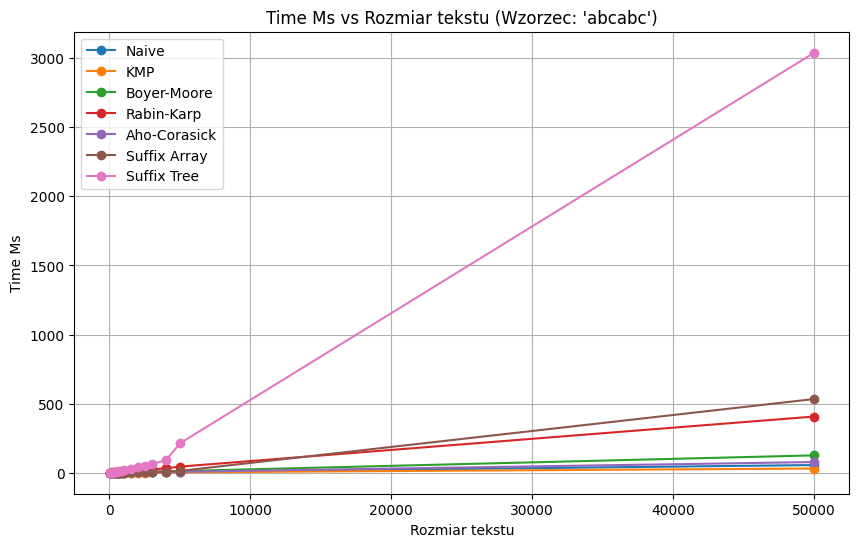

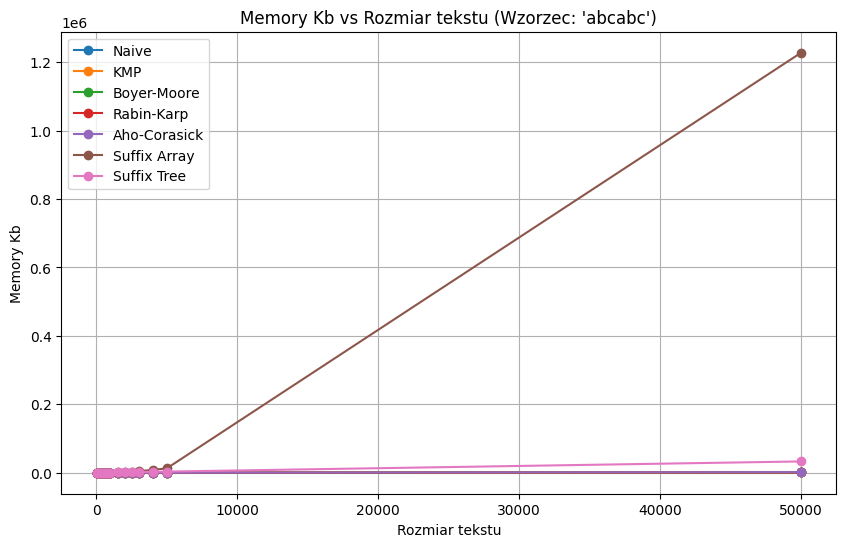

In [18]:
import sys
sys.setrecursionlimit(1000000)

text_sizes = [10,50, 100,200,400, 500,600,800, 1000,1500,2000,2500,3000,4000,5000,50000]
pattern = "abcabc"
results_all = {}

for size in text_sizes:
    text = "abc" * (size // 3)  # generuj powtarzalny tekst
    results = compare_pattern_matching_algorithms(text, pattern)
    results_all[size] = results

# Wykresy
plot_results_vs_text_size(text_sizes, pattern, list(results_all[text_sizes[0]].keys()), "time_ms", results_all)
plot_results_vs_text_size(text_sizes, pattern, list(results_all[text_sizes[0]].keys()), "memory_kb", results_all)
